Translation of the first example in the talk "[Emily Gorcenski - Polynomial Chaos: A technique for modeling uncertainty](https://www.youtube.com/watch?v=Z-Qio-n6yPc)". The idea is to approximate a general, potentially empirical, probability distribution using a suitable polynomial expansion (Polynomial/Wiener Chaos). With [Julia](https://github.com/JuliaLang/julia) and [PolyChaos](https://timueh.github.io/PolyChaos.jl/stable) package it simplified beautifully. For full explanation see related [blog post](https://john-hearn.info/articles/polynomial-chaos).

In [1]:
using PolyChaos, Distributions, Plots

First define our Hermite polynomials, $H_i(x)$
(called Gauss in PolyChaos because Hermite is reserved for the physicists Hermite polynomials which are slightly different).

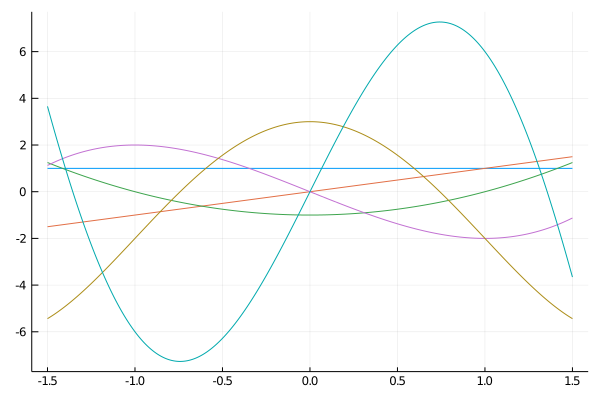

In [2]:
op_gauss = GaussOrthoPoly(20)
H(i) = x -> evaluate(i, x, op_gauss)
plot(-1.5:0.01:1.5, [ H(i) for i in 0:5 ], leg=false)

In [3]:
inv_cdf(dist) = u -> quantile(dist, u)

h = inv_cdf(Exponential())
l = inv_cdf(Normal())

#5 (generic function with 1 method)

PolyChaos calculates our inner (scalar) product for us, conveniently. 

The integrand is just the Galerkin projection with the transformed functions, $h(u)$ and $l(u)$.

In [7]:
sp = computeSP2(op_gauss)
integrand(i) = u -> h(u)*H(i)(l(u))

integrand (generic function with 1 method)

Perform the integration up to $p$ polynomials, we can use PolyChaos for this too although any integration scheme works.

In [8]:
p = 5
int_op = Uniform01OrthoPoly(1000, addQuadrature=true)
ki = [integrate(integrand(i-1), int_op) / sp[i] for i in 1:p]

5-element Array{Float64,1}:
  0.9999993692484951
  0.9031921803407967
  0.29780023616476886
  0.03334230632910607
 -0.0024169819236717414

Now we have the $k_i$s to do the transform we can reconstitute the approximated distribution by adding up a load of transformed Gaussian random variables, $\zeta_i$.

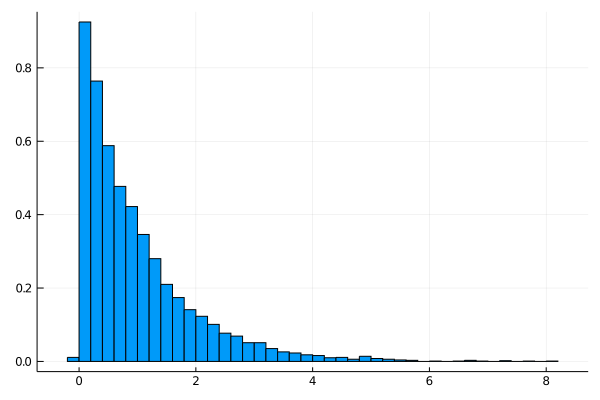

In [10]:
ζ = randn(5000)
Σ = zeros(5000)
for i in 1:p
    Σ += ki[i] * H(i-1)(ζ)
end
histogram(Σ, normed=true, leg=false)